In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [15]:
df = pd.read_csv('SolarPrediction.csv')
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [16]:
# Convert numeric columns
numeric_cols = ['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 'Humidity', 
                   'WindDirection(Degrees)', 'Speed']
    
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Convert timestamps
df['Timestamp'] = pd.to_datetime(df['Data'] + ' ' + df['Time'])
    
# Extract hour for time slices
df['Hour'] = df['Timestamp'].dt.hour

In [18]:
import tdmc
n_states=3
X = df[['Radiation', 'Temperature']].values
timestamps = df['Hour'].values
# Initialize and train the model
model = tdmc.SolarTDMC(n_states=n_states, n_emissions=2, time_slices=24)

# Define state names based on radiation levels
state_names = [f"State_{i}" for i in range(n_states)]

# Train the model
model.fit(
    X, timestamps, 
    max_iter=50, 
    state_names=state_names
)

In [19]:
from datetime import datetime, timedelta
def generate_forecast(model, df, forecast_horizon=24):
    """Generate a forecast using the trained TDMC model."""
    
    # Use the last observation as the starting point
    last_obs = df[['Radiation', 'Temperature']].values[-1]
    last_hour = df['Hour'].values[-1]
    
    # Generate forecast
    forecasts, (conf_lower, conf_upper) = model.forecast(
        last_obs, last_hour, forecast_horizon
    )
    
    # Create timestamp range for forecast
    if len(df) > 0:
        last_timestamp = pd.to_datetime(df['Data'].iloc[-1] + ' ' + df['Time'].iloc[-1])
        forecast_times = [last_timestamp + timedelta(hours=i+1) for i in range(forecast_horizon)]
    else:
        # Create default timestamps if dataframe is empty
        start_time = datetime.now()
        forecast_times = [start_time + timedelta(hours=i+1) for i in range(forecast_horizon)]
    
    # Create forecast dataframe
    forecast_df = pd.DataFrame({
        'Timestamp': forecast_times,
        'Hour': [t.hour for t in forecast_times],
        'Forecasted_Radiation': forecasts[:, 0],
        'Forecasted_Temperature': forecasts[:, 1],
        'Radiation_Lower_CI': conf_lower[:, 0],
        'Radiation_Upper_CI': conf_upper[:, 0],
        'Temperature_Lower_CI': conf_lower[:, 1],
        'Temperature_Upper_CI': conf_upper[:, 1]
    })
    
    return forecast_df

forecast_df = generate_forecast(model, df, forecast_horizon=24) 
    


In [20]:
def plot_forecast(forecast_df):
    """Plot the forecasted radiation and temperature."""
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot radiation forecast
    ax1.plot(forecast_df['Timestamp'], forecast_df['Forecasted_Radiation'], 'b-', label='Forecasted Radiation')
    ax1.fill_between(
        forecast_df['Timestamp'],
        forecast_df['Radiation_Lower_CI'],
        forecast_df['Radiation_Upper_CI'],
        alpha=0.3, color='b', label='95% Confidence Interval'
    )
    ax1.set_title('Radiation Forecast')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Radiation')
    ax1.legend()
    ax1.grid(True)
    
    # Plot temperature forecast
    ax2.plot(forecast_df['Timestamp'], forecast_df['Forecasted_Temperature'], 'r-', label='Forecasted Temperature')
    ax2.fill_between(
        forecast_df['Timestamp'],
        forecast_df['Temperature_Lower_CI'],
        forecast_df['Temperature_Upper_CI'],
        alpha=0.3, color='r', label='95% Confidence Interval'
    )
    ax2.set_title('Temperature Forecast')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Temperature (°F)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return fig


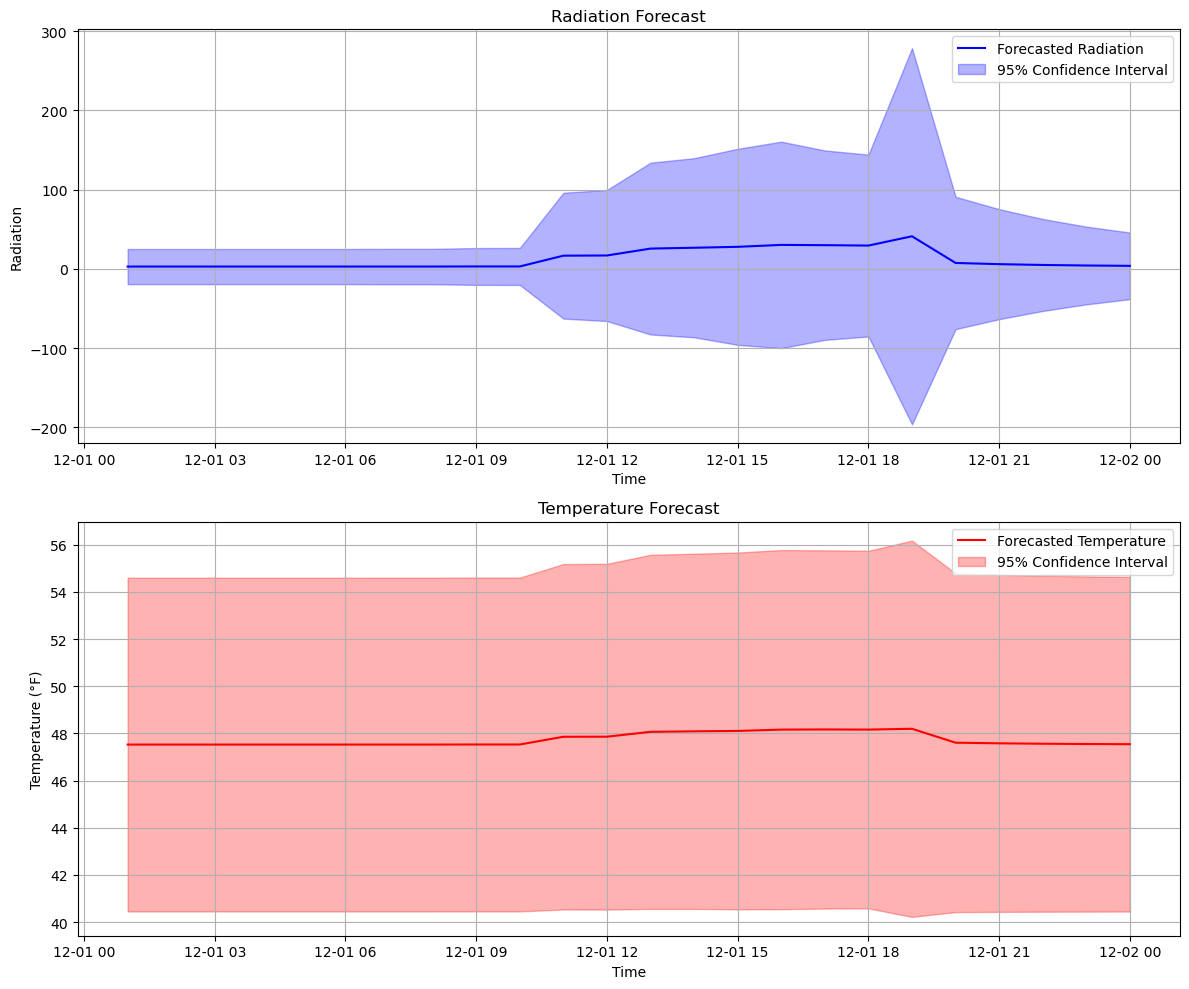

In [21]:
fig = plot_forecast(forecast_df)
plt.show()

In [7]:
    # Test the Markov property
markov_test = tdmc.plot_
print(f"\nMarkov Property Test: {markov_test['result']}")
print(f"Message: {markov_test['message']}")
    


TypeError: unsupported operand type(s) for -: 'chi2_gen' and 'int'

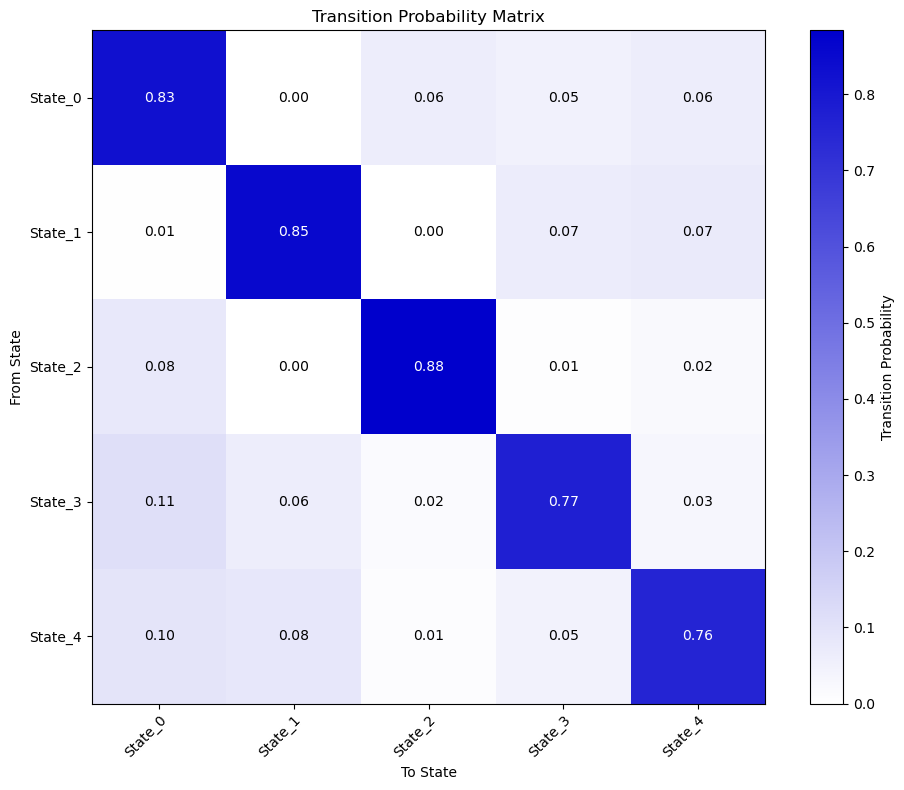

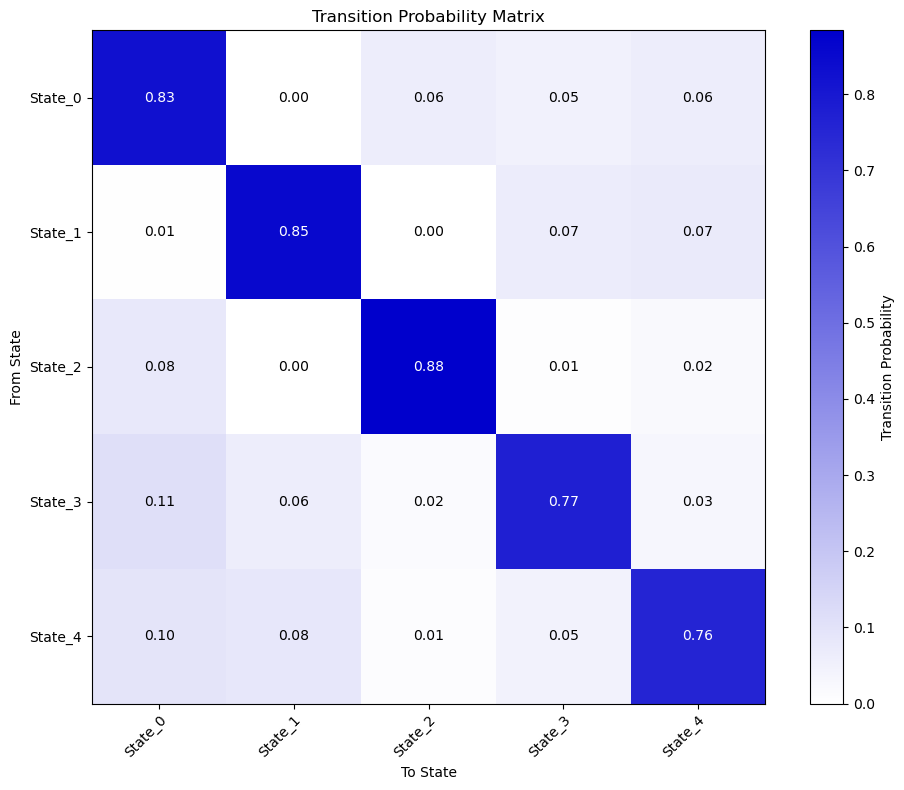

In [8]:
# Plot the transition matrix
dtmc.plot_transition_matrix()
    


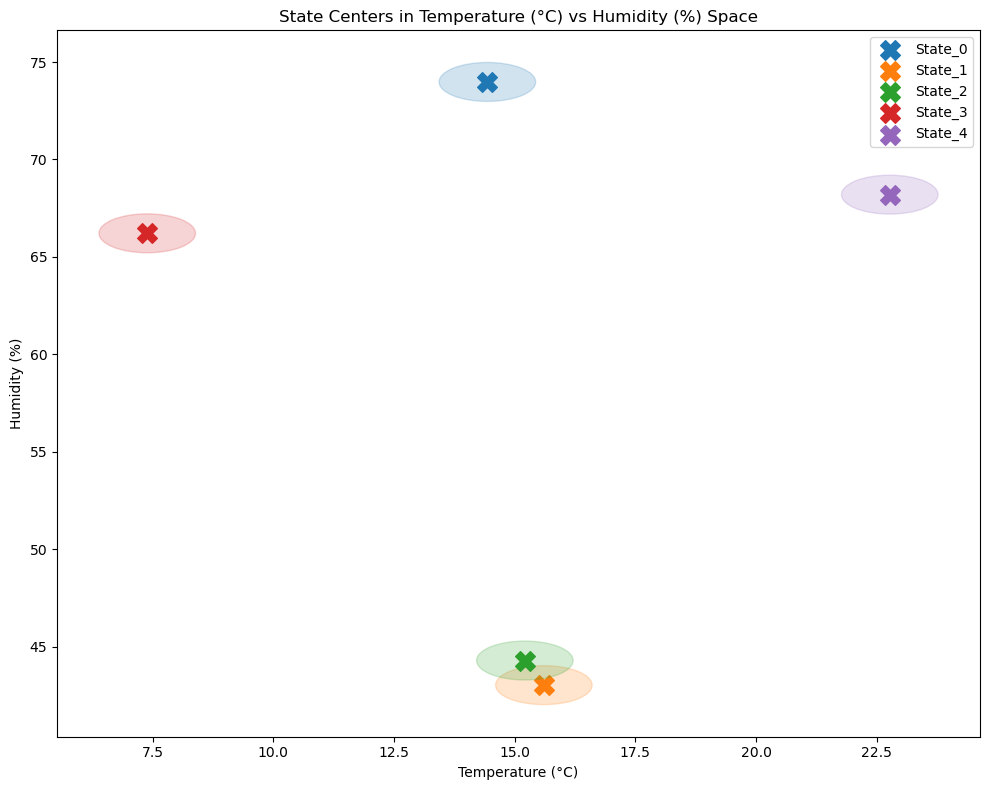

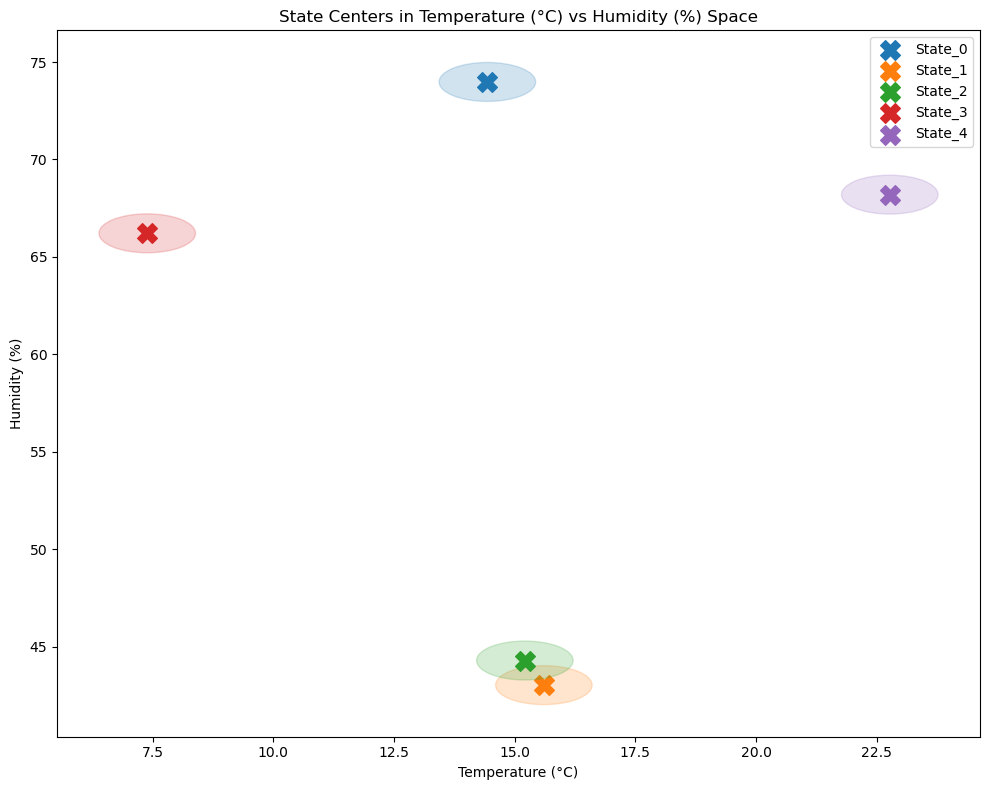

In [9]:
# Plot state distributions for the first two features
dtmc.plot_state_distributions([0, 1])